<a href="https://colab.research.google.com/github/haeseokoh/00_exchange/blob/main/%ED%94%BC%EC%96%B4%EC%95%A4%EA%B7%B8%EB%A6%AC%EB%93%9C%EC%98%A4%EC%8B%A4%EB%A0%88%EC%9D%B4%ED%84%B0_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 피어앤그리드.xlsx to 피어앤그리드.xlsx
KOSPI columns: Index(['Date', '5년 국채선물 추종 지수', '10년국채선물지수', '코스피 200 변동성지수', '코스피',
       '최근월물 CALL ATM', '최근월물 PUT ATM'],
      dtype='object')
KOSDAQ columns: Index(['Date', '5년 국채선물 추종 지수', '10년국채선물지수', '코스피 200 변동성지수', '코스닥',
       '최근월물 CALL ATM', '최근월물 PUT ATM'],
      dtype='object')
        Date  5년 국채선물 추종 지수  10년국채선물지수  코스피 200 변동성지수      코스피  최근월물 CALL ATM  \
0 2024-04-26         991.73    1173.33          18.32  2656.33          12884   
1 2024-04-29         991.36    1173.44          18.13  2687.44          33801   
2 2024-04-30         992.70    1177.15          18.14  2692.06          27943   
3 2024-05-02         993.45    1178.53          17.88  2683.65          31975   
4 2024-05-03         994.03    1180.54          17.51  2676.63           8772   

   최근월물 PUT ATM  
0          6025  
1          1688  
2          6411  
3          9679  
4         35279  
Date column successfully converted to datetime.


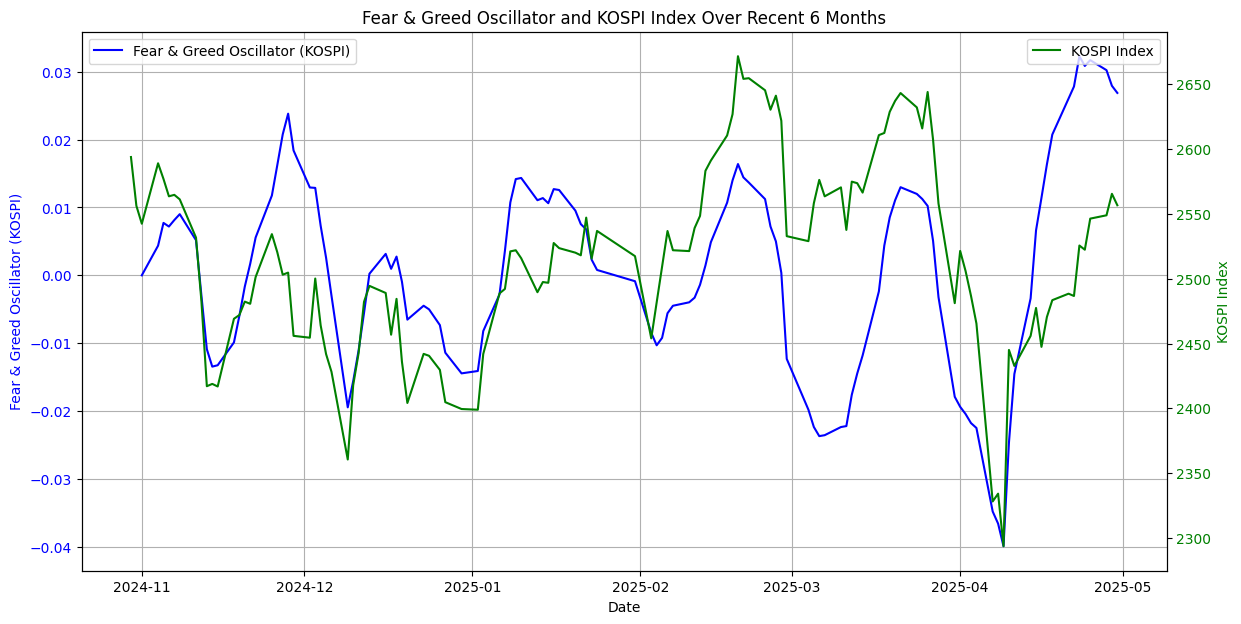

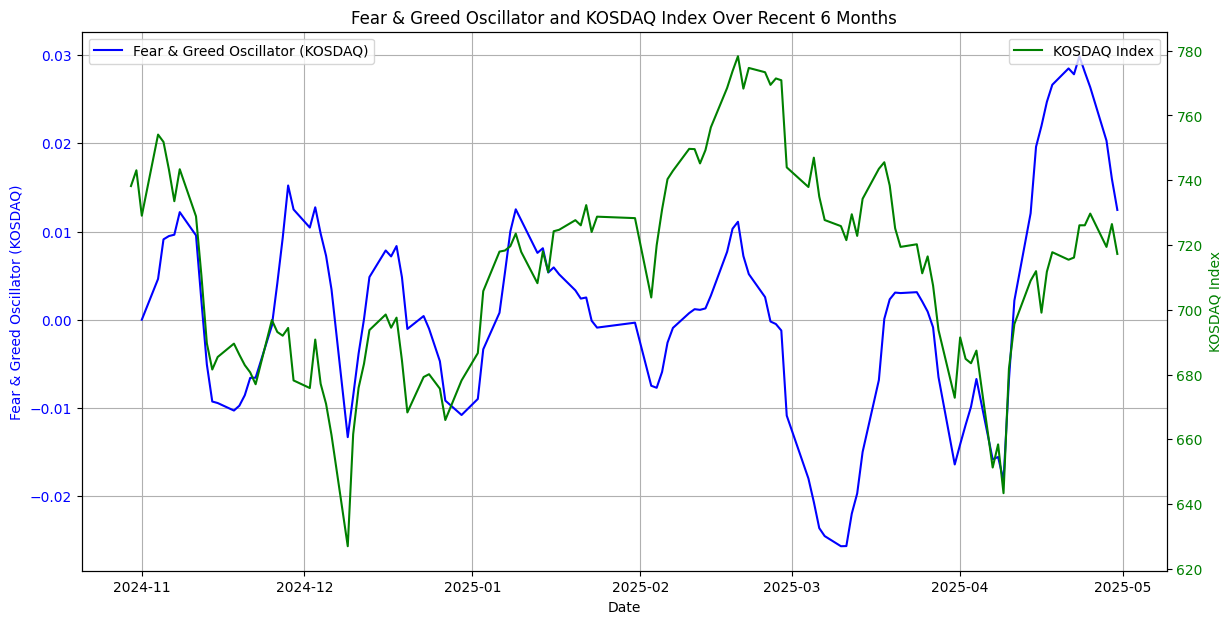

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.colab import files

# 엑셀 파일 업로드
uploaded = files.upload()

# 엑셀 파일 불러오기 (파일 이름을 실제 업로드한 파일 이름으로 설정)
kospi_df = pd.read_excel('피어앤그리드.xlsx', sheet_name='KOSPI')
kosdaq_df = pd.read_excel('피어앤그리드.xlsx', sheet_name='KOSDAQ')

# 각 데이터프레임의 열 이름을 출력하여 확인
print("KOSPI columns:", kospi_df.columns)
print("KOSDAQ columns:", kosdaq_df.columns)

# 'Date' 열이 제대로 불러와졌는지 확인
print(kospi_df.head())

# 2. 날짜 형식 변환 (열 이름 'Date' 사용)
try:
    kospi_df['Date'] = pd.to_datetime(kospi_df['Date'])
    kosdaq_df['Date'] = pd.to_datetime(kosdaq_df['Date'])
    print("Date column successfully converted to datetime.")
except KeyError as e:
    print(f"KeyError: {e}. Check if the 'Date' column exists and is correctly named.")

# 3. 수치형 데이터 처리
for col in ['5년 국채선물 추종 지수', '10년국채선물지수', '코스피 200 변동성지수', '코스피', '최근월물 CALL ATM', '최근월물 PUT ATM']:
    kospi_df[col] = pd.to_numeric(kospi_df[col], errors='coerce')
for col in ['5년 국채선물 추종 지수', '10년국채선물지수', '코스피 200 변동성지수', '코스닥', '최근월물 CALL ATM', '최근월물 PUT ATM']:
    kosdaq_df[col] = pd.to_numeric(kosdaq_df[col], errors='coerce')

# 4. 데이터 정리: NaN 값 제거
kospi_cleaned = kospi_df.dropna().copy()
kosdaq_cleaned = kosdaq_df.dropna().copy()

# 5. RSI 계산 함수
def calculate_rsi(df, column, window=10):
    delta = df[column].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    df.loc[:, 'RSI_10'] = rsi
    return df

# 6. Fear & Greed Index 계산 함수
def calculate_fear_greed(df, index_col, vix_col, call_vol_col, put_vol_col, bond_5y_col, bond_10y_col):
    df.loc[:, '125_MA'] = df[index_col].rolling(window=125).mean()
    df.loc[:, 'Momentum'] = (df[index_col] - df['125_MA']) / df['125_MA'] * 100
    df.loc[:, 'Put_Call_Ratio'] = df[put_vol_col] / df[call_vol_col]
    df.loc[:, 'Market_Volatility'] = df[vix_col]
    df.loc[:, 'Bond_Yield_Diff'] = df[bond_10y_col] - df[bond_5y_col]

    scaler = MinMaxScaler()
    df[['Momentum', 'Put_Call_Ratio', 'Market_Volatility', 'Bond_Yield_Diff', 'RSI_10']] = scaler.fit_transform(
        df[['Momentum', 'Put_Call_Ratio', 'Market_Volatility', 'Bond_Yield_Diff', 'RSI_10']]
    )

    df.loc[:, 'Fear_Greed_Index'] = (
        df['Momentum'] * 0.2 +
        (1 - df['Put_Call_Ratio']) * 0.2 +
        (1 - df['Market_Volatility']) * 0.2 +
        df['Bond_Yield_Diff'] * 0.2 +
        df['RSI_10'] * 0.2
    )

    return df

# 7. MACD 오실레이터 계산 함수
def calculate_macd(df, column, short_window=12, long_window=26, signal_window=9):
    df.loc[:, 'Short_EMA'] = df[column].ewm(span=short_window, adjust=False).mean()
    df.loc[:, 'Long_EMA'] = df[column].ewm(span=long_window, adjust=False).mean()
    df.loc[:, 'MACD'] = df['Short_EMA'] - df['Long_EMA']
    df.loc[:, 'Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    df.loc[:, 'Oscillator'] = df['MACD'] - df['Signal_Line']
    return df

# 8. RSI 계산 실행 (KOSPI 및 KOSDAQ)
kospi_cleaned = calculate_rsi(kospi_cleaned, '코스피')
kosdaq_cleaned = calculate_rsi(kosdaq_cleaned, '코스닥')

# 9. Fear & Greed Index 계산 실행
kospi_cleaned = calculate_fear_greed(kospi_cleaned, '코스피', '코스피 200 변동성지수', '최근월물 CALL ATM', '최근월물 PUT ATM', '5년 국채선물 추종 지수', '10년국채선물지수')
kosdaq_cleaned = calculate_fear_greed(kosdaq_cleaned, '코스닥', '코스피 200 변동성지수', '최근월물 CALL ATM', '최근월물 PUT ATM', '5년 국채선물 추종 지수', '10년국채선물지수')

# 10. MACD 오실레이터 계산 실행
kospi_cleaned = calculate_macd(kospi_cleaned, column='Fear_Greed_Index')
kosdaq_cleaned = calculate_macd(kosdaq_cleaned, column='Fear_Greed_Index')

# 11. 최근 6개월 데이터 필터링 ('Date' 열 사용)
recent_6months_kospi_cleaned = kospi_cleaned[kospi_cleaned['Date'] >= (kospi_cleaned['Date'].max() - pd.DateOffset(months=6))]
recent_6months_kosdaq_cleaned = kosdaq_cleaned[kosdaq_cleaned['Date'] >= (kosdaq_cleaned['Date'].max() - pd.DateOffset(months=6))]

# 12. KOSPI Fear & Greed 오실레이터와 KOSPI 지수 그래프 그리기
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(recent_6months_kospi_cleaned['Date'], recent_6months_kospi_cleaned['Oscillator'], label='Fear & Greed Oscillator (KOSPI)', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fear & Greed Oscillator (KOSPI)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(recent_6months_kospi_cleaned['Date'], recent_6months_kospi_cleaned['코스피'], label='KOSPI Index', color='g')
ax2.set_ylabel('KOSPI Index', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='upper right')

plt.title('Fear & Greed Oscillator and KOSPI Index Over Recent 6 Months')
plt.show()

# 13. KOSDAQ Fear & Greed 오실레이터와 KOSDAQ 지수 그래프 그리기
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(recent_6months_kosdaq_cleaned['Date'], recent_6months_kosdaq_cleaned['Oscillator'], label='Fear & Greed Oscillator (KOSDAQ)', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fear & Greed Oscillator (KOSDAQ)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(recent_6months_kosdaq_cleaned['Date'], recent_6months_kosdaq_cleaned['코스닥'], label='KOSDAQ Index', color='g')
ax2.set_ylabel('KOSDAQ Index', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='upper right')

plt.title('Fear & Greed Oscillator and KOSDAQ Index Over Recent 6 Months')
plt.show()
